<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/Assignment_6_Batch_Normalization_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


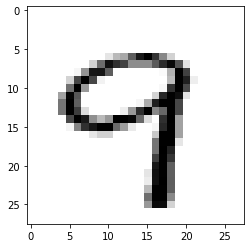

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

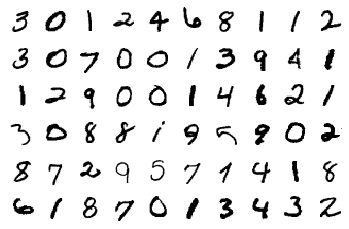

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12941215932369232 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.12559382617473602 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:17<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.028160355985164642 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.039210643619298935 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.04496853053569794 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.021196573972702026 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.03559084236621857 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.0153800742700696 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.0426451750099659 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.011535704135894775 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.02469179965555668 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.04357081651687622 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.00957709550857544 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.020598113536834717 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.022736931219697 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.06246640160679817 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.06537051498889923 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.05448504164814949 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.013710101135075092 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:18<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.04289260506629944 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.005385935306549072 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.03820165991783142 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.012584075331687927 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


Loss=0.009891699068248272 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 24


Loss=0.005167330149561167 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.05889064446091652 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 26


Loss=0.008833860047161579 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:18<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.01706884242594242 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:18<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 28


Loss=0.03374466672539711 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9947/10000 (99.47%)

EPOCH: 29


Loss=0.010925685055553913 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:17<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.012725849635899067 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 31


Loss=0.010527382604777813 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.011016841046512127 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.008671765215694904 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 34


Loss=0.009934057481586933 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:18<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.006548678036779165 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9947/10000 (99.47%)

EPOCH: 36


Loss=0.02321038208901882 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9953/10000 (99.53%)

EPOCH: 37


Loss=0.01948501169681549 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9953/10000 (99.53%)

EPOCH: 38


Loss=0.010124360211193562 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 39


Loss=0.02673870325088501 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:18<00:00, 30.51it/s]



Test set: Average loss: 0.0172, Accuracy: 9955/10000 (99.55%)



Text(0.5, 1.0, 'Test Accuracy')

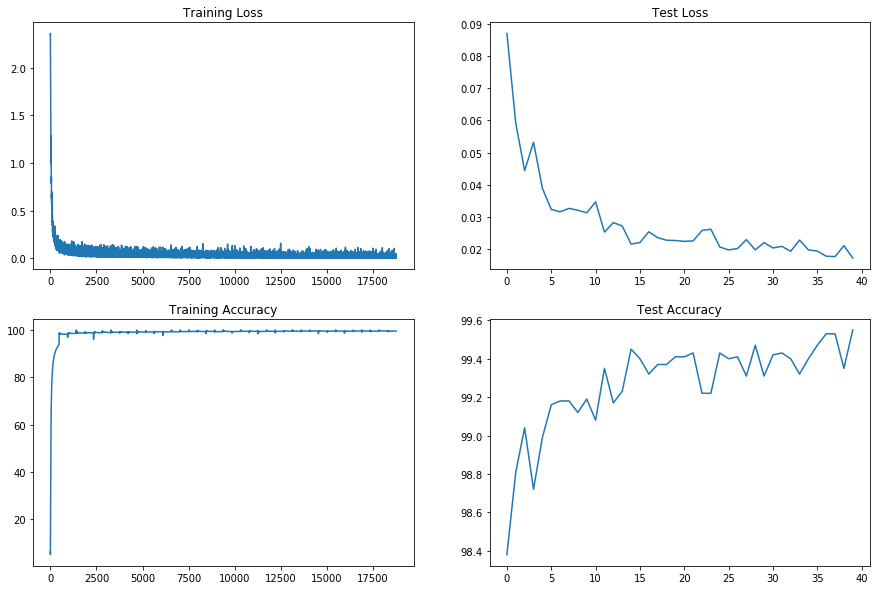

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## L1 Loss


In [0]:
from tqdm import tqdm

l1_train_losses = []
l1_test_losses = []
l1_train_acc = []
l1_test_acc = []

def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      if param.dim() > 1:
        reg_loss+=param.norm(1)
        #reg_loss += l1_crit(param)
      
    factor = 0.0005
    loss += factor * reg_loss
    l1_train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    l1_train_acc.append(100*correct/processed)

def l1_test(model, device, test_loader):
    model.eval()
    l1_test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            l1_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    l1_test_loss /= len(test_loader.dataset)
    l1_test_losses.append(l1_test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        l1_test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    l1_test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    l1_train(model, device, train_loader, optimizer, epoch)
    l1_test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.528140068054199 Batch_id=0 Accuracy=13.28:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.528140068054199 Batch_id=0 Accuracy=13.28:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=2.4843592643737793 Batch_id=1 Accuracy=12.11:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=2.4279935359954834 Batch_id=2 Accuracy=14.58:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=2.4279935359954834 Batch_id=2 Accuracy=14.58:   1%|          | 3/469 [00:00<01:40,  4.62it/s]
Loss=2.435486316680908 Batch_id=3 Accuracy=15.82:   1%|          | 3/469 [00:00<01:40,  4.62it/s] 
Loss=2.3575475215911865 Batch_id=4 Accuracy=18.91:   1%|          | 3/469 [00:00<01:40,  4.62it/s]
Loss=2.3575475215911865 Batch_id=4 Accuracy=18.91:   1%|          | 5/469 [00:00<01:19,  5.87it/s]
Loss=2.2633230686187744 Batch_id=5 Accuracy=22.66:   1%|          | 5/469 [00:00<01:19,  5.87it/s]
Loss=2.2437334060668945 Batch_id=6 Accuracy=25.22:   1%|          | 5/469 [00:00<01:19,  5.87it/s]
Loss=2.243733406066


Test set: Average loss: 0.0939, Accuracy: 9839/10000 (98.39%)

EPOCH: 1



Loss=0.36925381422042847 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.36925381422042847 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.2552027702331543 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:52,  2.71it/s] 
Loss=0.23319026827812195 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.23319026827812195 Batch_id=2 Accuracy=97.92:   1%|          | 3/469 [00:00<02:08,  3.62it/s]
Loss=0.25729602575302124 Batch_id=3 Accuracy=98.05:   1%|          | 3/469 [00:00<02:08,  3.62it/s]
Loss=0.26790618896484375 Batch_id=4 Accuracy=97.81:   1%|          | 3/469 [00:00<02:08,  3.62it/s]
Loss=0.303408145904541 Batch_id=5 Accuracy=97.79:   1%|          | 3/469 [00:00<02:08,  3.62it/s]  
Loss=0.303408145904541 Batch_id=5 Accuracy=97.79:   1%|▏         | 6/469 [00:00<01:35,  4.83it/s]
Loss=0.34484851360321045 Batch_id=6 Accuracy=97.77:   1%|▏         | 6/469 [00:00<01:35,  4.83it/s]
Loss=0.25


Test set: Average loss: 0.0820, Accuracy: 9791/10000 (97.91%)

EPOCH: 2



Loss=0.2392805814743042 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2392805814743042 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:51,  2.72it/s]
Loss=0.24729599058628082 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:51,  2.72it/s]
Loss=0.19710858166217804 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:51,  2.72it/s]
Loss=0.19710858166217804 Batch_id=2 Accuracy=97.66:   1%|          | 3/469 [00:00<02:06,  3.67it/s]
Loss=0.2622864246368408 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<02:06,  3.67it/s] 
Loss=0.2352062463760376 Batch_id=4 Accuracy=97.34:   1%|          | 3/469 [00:00<02:06,  3.67it/s]
Loss=0.2352062463760376 Batch_id=4 Accuracy=97.34:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=0.22741523385047913 Batch_id=5 Accuracy=97.40:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=0.17435547709465027 Batch_id=6 Accuracy=97.77:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=0.1743


Test set: Average loss: 0.0978, Accuracy: 9725/10000 (97.25%)

EPOCH: 3



Loss=0.15649138391017914 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.15649138391017914 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=0.1535392701625824 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s] 
Loss=0.14233697950839996 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=0.14233697950839996 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<01:56,  3.99it/s]
Loss=0.17217159271240234 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<01:56,  3.99it/s]
Loss=0.19467735290527344 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<01:56,  3.99it/s]
Loss=0.19467735290527344 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:28,  5.23it/s]
Loss=0.12677650153636932 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:28,  5.23it/s]
Loss=0.16929300129413605 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:28,  5.23it/s]
Loss=0.


Test set: Average loss: 0.0720, Accuracy: 9820/10000 (98.20%)

EPOCH: 4



Loss=0.14777207374572754 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.14777207374572754 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.13031059503555298 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.13248933851718903 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.13248933851718903 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.12390507757663727 Batch_id=3 Accuracy=99.22:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.12013228237628937 Batch_id=4 Accuracy=99.38:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.12013228237628937 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:33,  4.98it/s]
Loss=0.15112167596817017 Batch_id=5 Accuracy=98.96:   1%|          | 5/469 [00:00<01:33,  4.98it/s]
Loss=0.1430296152830124 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:33,  4.98it/s] 
Loss=0.


Test set: Average loss: 0.0624, Accuracy: 9855/10000 (98.55%)

EPOCH: 5



Loss=0.126413494348526 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.126413494348526 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.170877605676651 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.1473565399646759 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.15923842787742615 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.15923842787742615 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<02:04,  3.73it/s]
Loss=0.15254364907741547 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<02:04,  3.73it/s]
Loss=0.17786440253257751 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<02:04,  3.73it/s]
Loss=0.17786440253257751 Batch_id=5 Accuracy=98.18:   1%|▏         | 6/469 [00:00<01:34,  4.88it/s]
Loss=0.12649068236351013 Batch_id=6 Accuracy=98.21:   1%|▏         | 6/469 [00:00<01:34,  4.88it/s]
Loss=0.1778049


Test set: Average loss: 0.0634, Accuracy: 9824/10000 (98.24%)

EPOCH: 6



Loss=0.18307000398635864 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18307000398635864 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.46it/s]
Loss=0.16202005743980408 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.46it/s]
Loss=0.1267872303724289 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:15,  3.46it/s] 
Loss=0.1267872303724289 Batch_id=2 Accuracy=98.70:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Loss=0.1865762174129486 Batch_id=3 Accuracy=98.05:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Loss=0.15005247294902802 Batch_id=4 Accuracy=98.12:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Loss=0.15005247294902802 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:20,  5.74it/s]
Loss=0.11188686639070511 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:20,  5.74it/s]
Loss=0.1381690353155136 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:20,  5.74it/s] 
Loss=0.13


Test set: Average loss: 0.0487, Accuracy: 9867/10000 (98.67%)

EPOCH: 7



Loss=0.13574840128421783 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13574840128421783 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:43,  2.86it/s]
Loss=0.16171184182167053 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:43,  2.86it/s]
Loss=0.1663297712802887 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<02:43,  2.86it/s] 
Loss=0.1663297712802887 Batch_id=2 Accuracy=97.14:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.1220872551202774 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.14453481137752533 Batch_id=4 Accuracy=97.97:   1%|          | 3/469 [00:00<02:02,  3.81it/s]
Loss=0.1255437284708023 Batch_id=5 Accuracy=98.05:   1%|          | 3/469 [00:00<02:02,  3.81it/s] 
Loss=0.1255437284708023 Batch_id=5 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:31,  5.03it/s]
Loss=0.1497384011745453 Batch_id=6 Accuracy=98.10:   1%|▏         | 6/469 [00:00<01:31,  5.03it/s]
Loss=0.1729


Test set: Average loss: 0.0632, Accuracy: 9825/10000 (98.25%)

EPOCH: 8



Loss=0.18639427423477173 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18639427423477173 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.1500488817691803 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<02:46,  2.81it/s] 
Loss=0.11706337332725525 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.11563652753829956 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.11563652753829956 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.14171193540096283 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.10240766406059265 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.10240766406059265 Batch_id=5 Accuracy=98.18:   1%|▏         | 6/469 [00:00<01:33,  4.98it/s]
Loss=0.16370370984077454 Batch_id=6 Accuracy=97.99:   1%|▏         | 6/469 [00:00<01:33,  4.98it/s]
Loss=0.


Test set: Average loss: 0.0392, Accuracy: 9893/10000 (98.93%)

EPOCH: 9



Loss=0.15682238340377808 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.15682238340377808 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:43,  2.87it/s]
Loss=0.1203506588935852 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:43,  2.87it/s] 
Loss=0.11326809227466583 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:43,  2.87it/s]
Loss=0.14695660769939423 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:43,  2.87it/s]
Loss=0.14695660769939423 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<02:00,  3.87it/s]
Loss=0.16797563433647156 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<02:00,  3.87it/s]
Loss=0.1540791094303131 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<02:00,  3.87it/s] 
Loss=0.15897837281227112 Batch_id=6 Accuracy=98.21:   1%|          | 4/469 [00:00<02:00,  3.87it/s]
Loss=0.15897837281227112 Batch_id=6 Accuracy=98.21:   1%|▏         | 7/469 [00:00<01:29,  5.17it/s]
Loss=0.


Test set: Average loss: 0.0467, Accuracy: 9874/10000 (98.74%)

EPOCH: 10



Loss=0.11357701569795609 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11357701569795609 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=0.11491727828979492 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=0.09932209551334381 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=0.09932209551334381 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<01:55,  4.04it/s]
Loss=0.15783555805683136 Batch_id=3 Accuracy=98.63:   1%|          | 3/469 [00:00<01:55,  4.04it/s]
Loss=0.12991179525852203 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<01:55,  4.04it/s]
Loss=0.12991179525852203 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:29,  5.21it/s]
Loss=0.19787278771400452 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:29,  5.21it/s]
Loss=0.14632686972618103 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:29,  5.21it/s]
Loss=0.


Test set: Average loss: 0.0446, Accuracy: 9870/10000 (98.70%)

EPOCH: 11



Loss=0.13974866271018982 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13974866271018982 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.12717746198177338 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.10797308385372162 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.10797308385372162 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<02:05,  3.72it/s]
Loss=0.11251392960548401 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<02:05,  3.72it/s]
Loss=0.11482447385787964 Batch_id=4 Accuracy=98.91:   1%|          | 3/469 [00:00<02:05,  3.72it/s]
Loss=0.1415732204914093 Batch_id=5 Accuracy=98.70:   1%|          | 3/469 [00:00<02:05,  3.72it/s] 
Loss=0.1415732204914093 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:32,  4.98it/s]
Loss=0.14478477835655212 Batch_id=6 Accuracy=98.55:   1%|▏         | 6/469 [00:00<01:32,  4.98it/s]
Loss=0.1


Test set: Average loss: 0.0492, Accuracy: 9852/10000 (98.52%)

EPOCH: 12



Loss=0.13839808106422424 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13839808106422424 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:44,  2.84it/s]
Loss=0.13906097412109375 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:44,  2.84it/s]
Loss=0.12479642033576965 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:44,  2.84it/s]
Loss=0.12479642033576965 Batch_id=2 Accuracy=97.92:   1%|          | 3/469 [00:00<02:02,  3.80it/s]
Loss=0.1328449845314026 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<02:02,  3.80it/s] 
Loss=0.12730713188648224 Batch_id=4 Accuracy=97.66:   1%|          | 3/469 [00:00<02:02,  3.80it/s]
Loss=0.12730713188648224 Batch_id=4 Accuracy=97.66:   1%|          | 5/469 [00:00<01:32,  5.00it/s]
Loss=0.1432935893535614 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:32,  5.00it/s] 
Loss=0.15000484883785248 Batch_id=6 Accuracy=97.77:   1%|          | 5/469 [00:00<01:32,  5.00it/s]
Loss=0.


Test set: Average loss: 0.0389, Accuracy: 9896/10000 (98.96%)

EPOCH: 13



Loss=0.10922821611166 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.10922821611166 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.14315611124038696 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.12026742100715637 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.12026742100715637 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<01:59,  3.91it/s]
Loss=0.14619557559490204 Batch_id=3 Accuracy=98.24:   1%|          | 3/469 [00:00<01:59,  3.91it/s]
Loss=0.13778705894947052 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<01:59,  3.91it/s]
Loss=0.13778705894947052 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:30,  5.14it/s]
Loss=0.09654238820075989 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:30,  5.14it/s]
Loss=0.1794310212135315 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:30,  5.14it/s] 
Loss=0.097268


Test set: Average loss: 0.0400, Accuracy: 9877/10000 (98.77%)

EPOCH: 14



Loss=0.11415719985961914 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11415719985961914 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:21,  3.32it/s]
Loss=0.14104196429252625 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:21,  3.32it/s]
Loss=0.13633370399475098 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:21,  3.32it/s]
Loss=0.13633370399475098 Batch_id=2 Accuracy=97.92:   1%|          | 3/469 [00:00<01:48,  4.29it/s]
Loss=0.13813962042331696 Batch_id=3 Accuracy=98.05:   1%|          | 3/469 [00:00<01:48,  4.29it/s]
Loss=0.18078216910362244 Batch_id=4 Accuracy=98.12:   1%|          | 3/469 [00:00<01:48,  4.29it/s]
Loss=0.18078216910362244 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:23,  5.53it/s]
Loss=0.09844676405191422 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:23,  5.53it/s]
Loss=0.12108911573886871 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:23,  5.53it/s]
Loss=0.


Test set: Average loss: 0.0550, Accuracy: 9823/10000 (98.23%)

EPOCH: 15



Loss=0.09999087452888489 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.09999087452888489 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.1567780077457428 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.71it/s]  
Loss=0.15276139974594116 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.15276139974594116 Batch_id=2 Accuracy=98.70:   1%|          | 3/469 [00:00<02:08,  3.63it/s]
Loss=0.11776117980480194 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<02:08,  3.63it/s]
Loss=0.16395357251167297 Batch_id=4 Accuracy=98.44:   1%|          | 3/469 [00:00<02:08,  3.63it/s]
Loss=0.12157556414604187 Batch_id=5 Accuracy=98.57:   1%|          | 3/469 [00:00<02:08,  3.63it/s]
Loss=0.12157556414604187 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:34,  4.89it/s]
Loss=0.10991454869508743 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469 [00:00<01:34,  4.89it/s]
Loss


Test set: Average loss: 0.0429, Accuracy: 9867/10000 (98.67%)

EPOCH: 16



Loss=0.11013254523277283 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11013254523277283 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:15,  3.47it/s]
Loss=0.14358903467655182 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:15,  3.47it/s]
Loss=0.14358903467655182 Batch_id=1 Accuracy=98.05:   0%|          | 2/469 [00:00<01:50,  4.24it/s]
Loss=0.10150963068008423 Batch_id=2 Accuracy=98.70:   0%|          | 2/469 [00:00<01:50,  4.24it/s]
Loss=0.18761414289474487 Batch_id=3 Accuracy=98.24:   0%|          | 2/469 [00:00<01:50,  4.24it/s]
Loss=0.18761414289474487 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:24,  5.53it/s]
Loss=0.13432343304157257 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<01:24,  5.53it/s]
Loss=0.16480019688606262 Batch_id=5 Accuracy=98.05:   1%|          | 4/469 [00:00<01:24,  5.53it/s]
Loss=0.16480019688606262 Batch_id=5 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:09,  6.67it/s]
Loss=0.


Test set: Average loss: 0.0507, Accuracy: 9854/10000 (98.54%)

EPOCH: 17



Loss=0.11431872844696045 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11431872844696045 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:38,  2.96it/s]
Loss=0.12101809680461884 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:38,  2.96it/s]
Loss=0.14802981913089752 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:38,  2.96it/s]
Loss=0.14802981913089752 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<01:57,  3.96it/s]
Loss=0.13732822239398956 Batch_id=3 Accuracy=98.44:   1%|          | 3/469 [00:00<01:57,  3.96it/s]
Loss=0.18152214586734772 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<01:57,  3.96it/s]
Loss=0.18704907596111298 Batch_id=5 Accuracy=98.18:   1%|          | 3/469 [00:00<01:57,  3.96it/s]
Loss=0.18704907596111298 Batch_id=5 Accuracy=98.18:   1%|▏         | 6/469 [00:00<01:28,  5.25it/s]
Loss=0.14001122117042542 Batch_id=6 Accuracy=98.21:   1%|▏         | 6/469 [00:00<01:28,  5.25it/s]
Loss=0.


Test set: Average loss: 0.0639, Accuracy: 9796/10000 (97.96%)

EPOCH: 18



Loss=0.19247445464134216 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19247445464134216 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.20616835355758667 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.10567629337310791 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.10567629337310791 Batch_id=2 Accuracy=97.40:   1%|          | 3/469 [00:00<01:52,  4.13it/s]
Loss=0.12145176529884338 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<01:52,  4.13it/s]
Loss=0.09408020228147507 Batch_id=4 Accuracy=98.12:   1%|          | 3/469 [00:00<01:52,  4.13it/s]
Loss=0.09408020228147507 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:26,  5.36it/s]
Loss=0.12455916404724121 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<01:26,  5.36it/s]
Loss=0.10092191398143768 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:26,  5.36it/s]
Loss=0.


Test set: Average loss: 0.0473, Accuracy: 9853/10000 (98.53%)

EPOCH: 19



Loss=0.19227635860443115 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19227635860443115 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:29,  3.14it/s]
Loss=0.09812904894351959 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:29,  3.14it/s]
Loss=0.19535043835639954 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:29,  3.14it/s]
Loss=0.19535043835639954 Batch_id=2 Accuracy=97.92:   1%|          | 3/469 [00:00<01:53,  4.09it/s]
Loss=0.1506703495979309 Batch_id=3 Accuracy=97.85:   1%|          | 3/469 [00:00<01:53,  4.09it/s] 
Loss=0.09608060866594315 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<01:53,  4.09it/s]
Loss=0.09608060866594315 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:27,  5.32it/s]
Loss=0.1043536514043808 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:27,  5.32it/s] 
Loss=0.19863712787628174 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:27,  5.32it/s]
Loss=0.


Test set: Average loss: 0.0404, Accuracy: 9883/10000 (98.83%)

EPOCH: 20



Loss=0.2649916112422943 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2649916112422943 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.1330508589744568 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.18022862076759338 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.11585527658462524 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:52,  2.71it/s]
Loss=0.11585527658462524 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.08869747817516327 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.10968532413244247 Batch_id=5 Accuracy=98.57:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.10968532413244247 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:36,  4.79it/s]
Loss=0.128377765417099 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469 [00:00<01:36,  4.79it/s]  
Loss=0.176


Test set: Average loss: 0.0405, Accuracy: 9889/10000 (98.89%)

EPOCH: 21



Loss=0.15545393526554108 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.15545393526554108 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:55,  2.67it/s]
Loss=0.0982738733291626 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:55,  2.67it/s] 
Loss=0.14235657453536987 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:55,  2.67it/s]
Loss=0.1337965726852417 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:55,  2.67it/s] 
Loss=0.1337965726852417 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<02:09,  3.60it/s]
Loss=0.1840478777885437 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<02:09,  3.60it/s]
Loss=0.09968412667512894 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<02:09,  3.60it/s]
Loss=0.18670415878295898 Batch_id=6 Accuracy=98.33:   1%|          | 4/469 [00:00<02:09,  3.60it/s]
Loss=0.18670415878295898 Batch_id=6 Accuracy=98.33:   1%|▏         | 7/469 [00:00<01:35,  4.83it/s]
Loss=0.11


Test set: Average loss: 0.0420, Accuracy: 9874/10000 (98.74%)

EPOCH: 22



Loss=0.1726790964603424 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1726790964603424 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:50,  2.74it/s]
Loss=0.1361425518989563 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:50,  2.74it/s]
Loss=0.16734781861305237 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:50,  2.74it/s]
Loss=0.1278754472732544 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:50,  2.74it/s] 
Loss=0.1278754472732544 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<02:05,  3.71it/s]
Loss=0.12194198369979858 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<02:05,  3.71it/s]
Loss=0.13481488823890686 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<02:05,  3.71it/s]
Loss=0.1515917181968689 Batch_id=6 Accuracy=98.10:   1%|          | 4/469 [00:00<02:05,  3.71it/s] 
Loss=0.1515917181968689 Batch_id=6 Accuracy=98.10:   1%|▏         | 7/469 [00:00<01:33,  4.96it/s]
Loss=0.10529


Test set: Average loss: 0.0339, Accuracy: 9910/10000 (99.10%)

EPOCH: 23



Loss=0.14216424524784088 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.14216424524784088 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:54,  2.68it/s]
Loss=0.10628806799650192 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:54,  2.68it/s]
Loss=0.10135538876056671 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:54,  2.68it/s]
Loss=0.10135538876056671 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<02:10,  3.57it/s]
Loss=0.14380046725273132 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<02:10,  3.57it/s]
Loss=0.15500661730766296 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<02:10,  3.57it/s]
Loss=0.11633937060832977 Batch_id=5 Accuracy=98.70:   1%|          | 3/469 [00:00<02:10,  3.57it/s]
Loss=0.11633937060832977 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:36,  4.77it/s]
Loss=0.13580437004566193 Batch_id=6 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:36,  4.77it/s]
Loss=0.


Test set: Average loss: 0.0393, Accuracy: 9879/10000 (98.79%)

EPOCH: 24



Loss=0.16859230399131775 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.16859230399131775 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.13438603281974792 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.13388417661190033 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.13388417661190033 Batch_id=2 Accuracy=97.40:   1%|          | 3/469 [00:00<02:03,  3.78it/s]
Loss=0.1323280781507492 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<02:03,  3.78it/s] 
Loss=0.1100732684135437 Batch_id=4 Accuracy=97.97:   1%|          | 3/469 [00:00<02:03,  3.78it/s]
Loss=0.14948242902755737 Batch_id=5 Accuracy=98.18:   1%|          | 3/469 [00:00<02:03,  3.78it/s]
Loss=0.14948242902755737 Batch_id=5 Accuracy=98.18:   1%|▏         | 6/469 [00:00<01:33,  4.97it/s]
Loss=0.20485420525074005 Batch_id=6 Accuracy=97.99:   1%|▏         | 6/469 [00:00<01:33,  4.97it/s]
Loss=0.1


Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

EPOCH: 25



Loss=0.11614055931568146 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11614055931568146 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.16311731934547424 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.11048013716936111 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.12093223631381989 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.12093223631381989 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<02:09,  3.59it/s]
Loss=0.13775596022605896 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<02:09,  3.59it/s]
Loss=0.09792265295982361 Batch_id=5 Accuracy=98.31:   1%|          | 4/469 [00:00<02:09,  3.59it/s]
Loss=0.09495316445827484 Batch_id=6 Accuracy=98.44:   1%|          | 4/469 [00:00<02:09,  3.59it/s]
Loss=0.09495316445827484 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469 [00:00<01:37,  4.72it/s]
Loss=0.


Test set: Average loss: 0.0388, Accuracy: 9875/10000 (98.75%)

EPOCH: 26



Loss=0.1367349922657013 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1367349922657013 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:53,  2.69it/s]
Loss=0.14610555768013 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:53,  2.69it/s]  
Loss=0.11034494638442993 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:53,  2.69it/s]
Loss=0.17253544926643372 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:53,  2.69it/s]
Loss=0.17253544926643372 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.18051207065582275 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.14968563616275787 Batch_id=5 Accuracy=97.92:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.15445540845394135 Batch_id=6 Accuracy=97.54:   1%|          | 4/469 [00:00<02:06,  3.67it/s]
Loss=0.15445540845394135 Batch_id=6 Accuracy=97.54:   1%|▏         | 7/469 [00:00<01:34,  4.90it/s]
Loss=0.135


Test set: Average loss: 0.0434, Accuracy: 9882/10000 (98.82%)

EPOCH: 27



Loss=0.08974026143550873 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08974026143550873 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.57it/s]
Loss=0.09506422281265259 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:11,  3.57it/s] 
Loss=0.09506422281265259 Batch_id=1 Accuracy=99.61:   0%|          | 2/469 [00:00<01:45,  4.41it/s]
Loss=0.17524629831314087 Batch_id=2 Accuracy=98.96:   0%|          | 2/469 [00:00<01:45,  4.41it/s]
Loss=0.1335172802209854 Batch_id=3 Accuracy=98.83:   0%|          | 2/469 [00:00<01:45,  4.41it/s] 
Loss=0.11442571878433228 Batch_id=4 Accuracy=98.75:   0%|          | 2/469 [00:00<01:45,  4.41it/s]
Loss=0.11442571878433228 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:21,  5.71it/s]
Loss=0.1344468742609024 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:21,  5.71it/s] 
Loss=0.10585819184780121 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:21,  5.71it/s]
Loss


Test set: Average loss: 0.0544, Accuracy: 9877/10000 (98.77%)

EPOCH: 28



Loss=0.10589423030614853 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.10589423030614853 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.09676752239465714 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.13707175850868225 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.13707175850868225 Batch_id=2 Accuracy=98.70:   1%|          | 3/469 [00:00<01:48,  4.31it/s]
Loss=0.10937950015068054 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<01:48,  4.31it/s]
Loss=0.16643622517585754 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<01:48,  4.31it/s]
Loss=0.16643622517585754 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:24,  5.52it/s]
Loss=0.11929798126220703 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:24,  5.52it/s]
Loss=0.12790310382843018 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:24,  5.52it/s]
Loss=0.

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(l1_train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(l1_train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(l1_test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(l1_test_acc)
axs[1, 1].set_title("Test Accuracy")